# VAE

In [6]:
!pip install k-diffusion

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [8]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [9]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [10]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

In [11]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [12]:
dl = dls.valid
xb, yb = b = next(iter(dl))

In [13]:
## Autoencoder

In [14]:
ni, nh, nl = 784, 400, 200

In [15]:
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act: layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [16]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

In [17]:
iw = partial(init_weights, leaky=0.1)
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl))
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
    
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [18]:
opt_func = partial(optim.Adam, eps=1e-5)

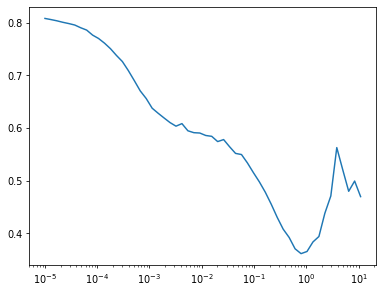

In [19]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [20]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoenc()
learn = Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.464,0,eval
0.400,1,train
0.352,1,eval
0.316,2,train
0.299,2,eval
0.286,3,train
0.284,3,eval
0.276,4,train
0.276,4,eval


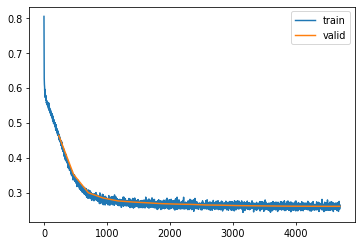

In [21]:
learn.fit(epochs)

In [24]:
# torch.save(model, '../models/vae_20.pkl')
learn.model = model = torch.load('../models/vae_20.pkl', map_location=torch.device(def_device))

In [25]:
with torch.no_grad(): t = to_cpu(model(xb.to(def_device)).float())

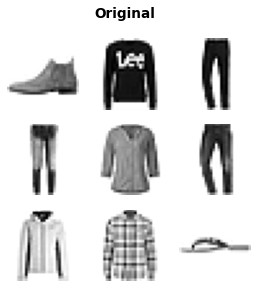

In [26]:
show_images(xb[:9].reshape(-1,1,28,28), imsize=1.5, title='Original');

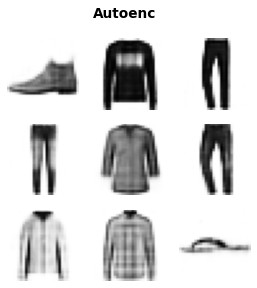

In [27]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='Autoenc');

In [28]:
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): generated_images = model.dec(noise).sigmoid()

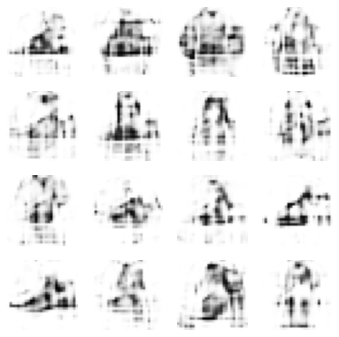

In [29]:
show_images(generated_images.reshape(-1, 1, 28, 28), imsize=1.5)